In [1]:
import numpy as np
import os
import tensorflow as tf
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import glob
import random
import time

%matplotlib inline

In [10]:
def load_model(file_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(file_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph
            
def load_image(image_path):
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference(sess, ops, image_tensor, image):
    output_dict = {}
    
    time_s = time.time()
    num_detections, boxes, scores, classes = sess.run(ops, feed_dict={image_tensor: image})
    time_t = time.time() - time_s
    
    output_dict['num_detections'] = int(num_detections[0])
    output_dict['detection_classes'] = classes[0].astype(np.uint8)
    output_dict['detection_boxes'] = boxes[0]
    output_dict['detection_scores'] = scores[0]
    output_dict['detection_time'] = time_t
    
    return output_dict

def detect_and_visualize(graph, image_paths, category_index):
    
    with graph.as_default():
    
        image_tensor = graph.get_tensor_by_name('image_tensor:0')
        boxes_tensor = graph.get_tensor_by_name('detection_boxes:0')
        scores_tensor = graph.get_tensor_by_name('detection_scores:0')
        classes_tensor = graph.get_tensor_by_name('detection_classes:0')
        detections_tensor = graph.get_tensor_by_name('num_detections:0')

        ops = [detections_tensor, boxes_tensor, scores_tensor, classes_tensor]

        with tf.Session() as sess:
            for image_path in image_paths:
                image = load_image(image_path)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image, axis=0)
                # Actual detection.
                output_dict = run_inference(sess, ops, image_tensor, image_np_expanded)
                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image,
                  output_dict['detection_boxes'],
                  output_dict['detection_classes'],
                  output_dict['detection_scores'],
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=3)
                plt.figure(figsize=(12, 8))
                plt.imshow(image)

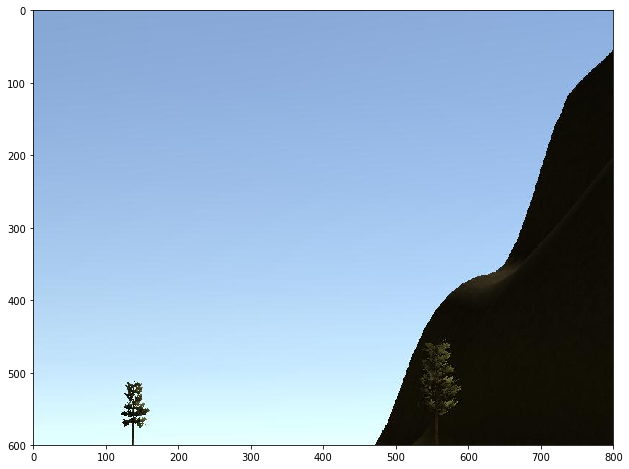

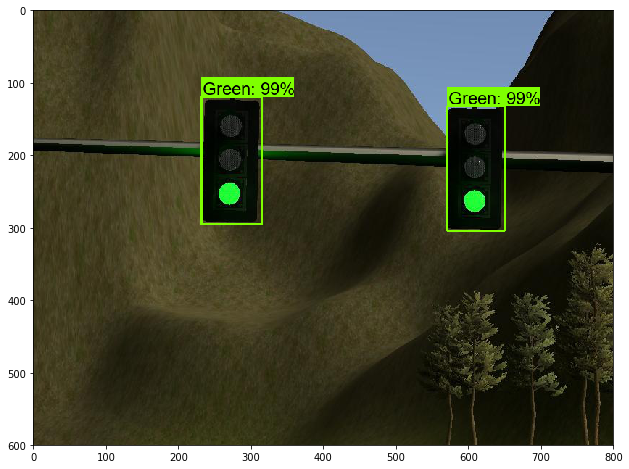

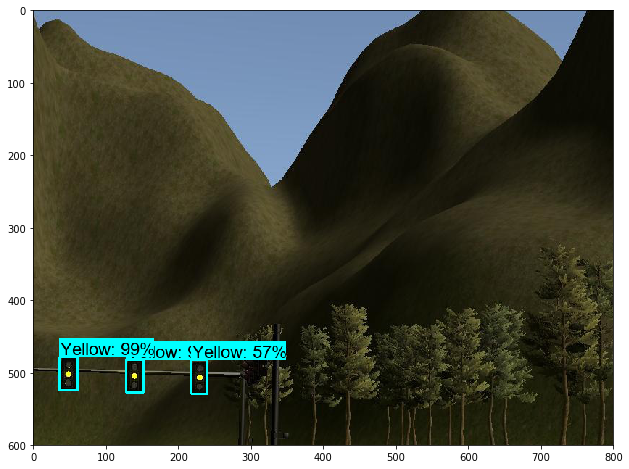

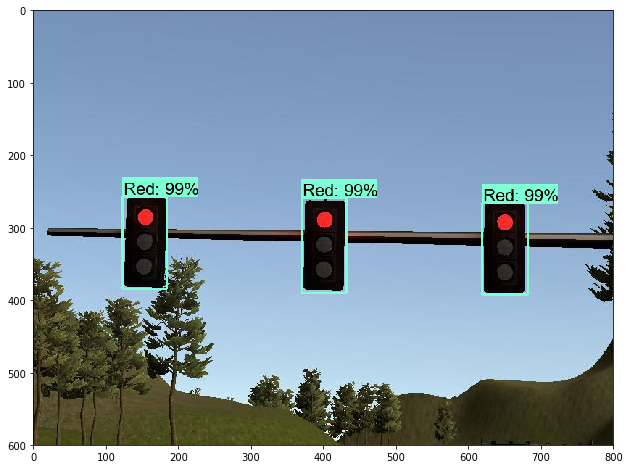

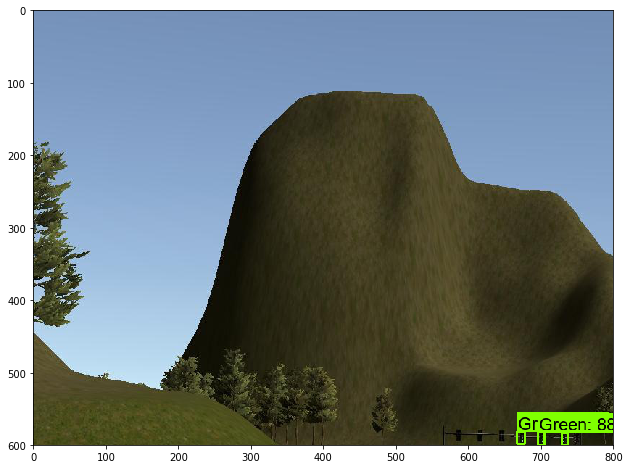

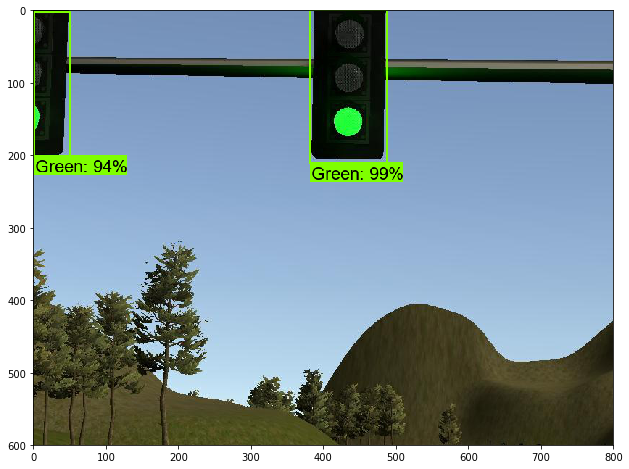

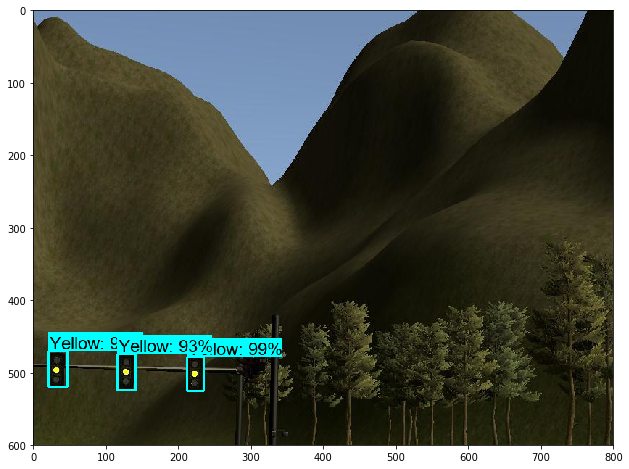

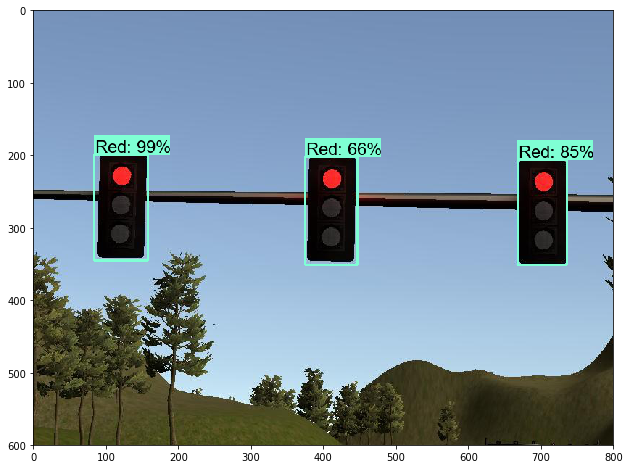

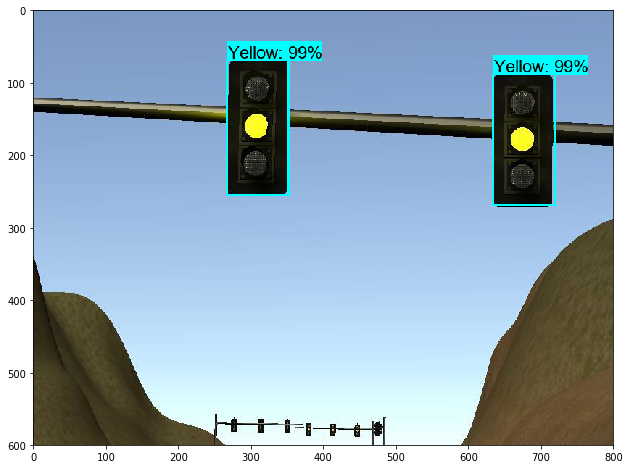

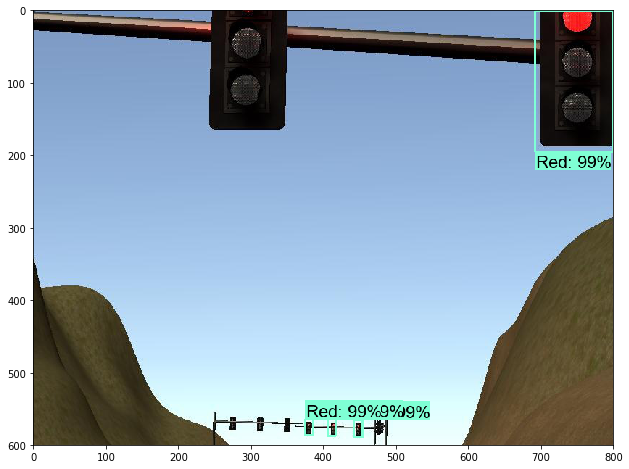

In [11]:
MODEL_PATH = os.path.join('models', 'frozen_inference_graph.pb')
TEST_IMAGES_DIR = os.path.join('data', 'simulator')
LABELS_MAP_PATH = os.path.join('config', 'labels_map.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(LABELS_MAP_PATH, use_display_name=True)
detection_graph = load_model(MODEL_PATH)
test_images = glob.glob(os.path.join(TEST_IMAGES_DIR, '*.jpg'))

random.shuffle(test_images)

test_images = test_images[:10]

detect_and_visualize(detection_graph, test_images, category_index)